# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this project, we will look at the major power outage data in the continental U.S. from January 2000 to July 2016. After data cleaning, the dataset has 1534 observations (each occurence of outage), and 56 columns (location, cause, influential factors, time-stamp, aftermath of the outage etc.)

The classification problem is that we want to predict the **cause category** (target variable) for each major power outages given the year, the state, outage duration, population of the state, number of customers affected for each state (features). And we'll use **Recall** as our evaluation metric to examine our model, and make further improvements based on the value. The justification for this metric over others will be given in Baseline model section.

### Baseline Model
Our baseline model uses the Decision Tree Classifier, since the `CAUSE.CATEGORY` consists of 7 categories,and including 5 features: [`'YEAR'`, `'U.S._STATE'`, `'OUTAGE.DURATION'`, `'POPULATION'`, `'CUSTOMERS.AFFECTED'`]. Of which, `YEAR` column is ordinal, `U.S. STATE` is nominal, and remaining three columns are quantitative variables.

The reason why we choose year as one of the features is that as time progresses, we guessed that cause category might also change correspondingly due to technological improvement. We chose state since the geography, demography, consumption varies among different states, which might have an effect on power outage. We chose outage duration, since the length of each outage can depend on the severity, which also closely linked to the cause category. The population is feasible since the population is a straight forward representation of the scale of the state, difference in population might also affect the cause. At last, if cause category belongs to a macro scale influence, naturally many customers will be affected, making customers affected another viable feature.

In addition,choosing a good evaluation metric is quite challenging,since the `CAUSE.CATEGORY` has 7 causes for the outage, each with very diverse amount (using value_counts), it's relatively hard to calculate recall, specifity, precision, and etc., only if we repeat them for each category (it will be much easier to work with since they are for binarized-categorical variable like the tumor/no tumor, or terrorists/non-terrorists example). To tackle this problem, we first define a variable `categories` that includes all causes, and then assign it for the keyword argument `labels` for the confusion matrix. To better visualize True Positive, False Positive, False Negative and True Negative, we used multi-labeled confusion matrix that displays all seven categories respectively in a more visually straightforward 2x2 matrices. Parallel to our expectation, the multi-label confusion matrix has matching True Positives as values on the diagonal line of the ordinary confusion matrix. Since there are 7 categories, and they have unequal proportion, we value True Positives over all observations that are actually labeled positive the most (unlike tumor problem, True Negative doesn't give much information in this case, recall is most helpful),

$$
{\rm Recall} =\frac{TP}{P} =\frac{TP}{TP + FN}
$$

which follows that we will use `Recall` as our evaluation metric. More specifically, we will take the mean of all 7 categories' `recall` as the evaluation metric using `recall_score`. However, our evaluation metric can be further improved since we consider the case where TP = 0 and TP + FN = 0 to get a recall of 0 (but if FN is non-zero, TP is 0, we also get 0, they don't mean the same thing since TP + FN = 0 suggests that there are no positive labels in the input data). 

After training our baseline model, it has a mean of 0.464 recall over all categories on testing dataset, which is quite decent considering we have 7 categories.

### Final Model
To achieve our final model, we attempted 2 feature engineering that would theoretically improve our evaluation metric. We first calculates the population density using:

$$
{\rm Population\ density} = \frac {POPPCT\_URBAN * POPDEN\_URBAN + (1 - POPPCT\_URBAN) * POPDEN\_RURAL}{100} 
$$

We think that it will be a very effective feature that could potentially increase our recall score, since population density can be an indicative measure for different causes. For example, major outages that occur within areas with higher population density might due to `system operability disruption`. The second is StandardScaler. It will transform our data such that its distribution will have a mean value 0 and standard deviation of 1. We applied this on other numeric columns. 

With these two additional features, we have increased our recall score to 0.593. Then, we performed Grid Search on this final pipeline to obtain the final model for our prediction. It gives that the best pipeline parameters are: {'dtc__max_depth': 5, 'dtc__min_samples_leaf': 2, 'dtc__min_samples_split': 17}.

The model can be further improved if Grid Search is able to optimize parameters based on recall score rather than accuracy.

### Fairness Evaluation
To assess the fairness and bias of our model, we specifically chose the column `POPPCT_URBAN` to construct our X and Y subsets and hypothesized that the urban population percentage doesn't affect our recall scores.

We will binarize our datasets into:

`1`: which has `POPPCT_URBAN` higher than the median urban population percentage;

`0`: which are lower than the median.

Our test statistic would be the **absolute difference** between the **recall score** of these two subsets. 

***Null Hypothesis***: Urban population percentage, either higher or lower than its' median, doesn't have an effect on our recall score.(i.e. the difference between the recall scores between two subsets are due to chance)

***Alternative Hypothesis***: The urban population percentage does influence our recall score on two subsets.

After running 1000 permutation tests, we obtained a p-value of 0.598. Pick a significance level 0.05, this is much higher than the threshold. Hence, we failed to reject our null hypothesis. This is saying that, according to our test, the urban population percentage has limited or no influence on the recall score. We failed to observe any parity between high urban population percentage areas and low urban population percentage areas when predicting the outage categories. 

# Code

We first import necessary packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

This section of the code processes and cleans the dataset.

In [73]:
pd.set_option('display.max_columns', 5)

In [74]:
df = pd.read_excel('outage.xlsx', skiprows = 5)
df = df.drop(0).drop(['variables','OBS'], axis = 1).reset_index(drop=True)
df

,YEAR,MONTH,...,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011.0,7.0,...,8.40733,5.47874
1,2014.0,5.0,...,8.40733,5.47874
2,2010.0,10.0,...,8.40733,5.47874
3,2012.0,6.0,...,8.40733,5.47874
4,2015.0,7.0,...,8.40733,5.47874
...,...,...,...,...,...
1529,2011.0,12.0,...,2.40177,2.40177
1530,2006.0,NaN,...,2.40177,2.40177
1531,2009.0,8.0,...,1.69226,1.69226
1532,2009.0,8.0,...,1.69226,1.69226


In [75]:
start_time = pd.to_datetime(
    df['OUTAGE.START.DATE'].dropna().astype(str).str.split(' ').str[0] 
    + ' ' 
    + df['OUTAGE.START.TIME'].dropna().astype(str)
)

restoration_time = pd.to_datetime(
    df['OUTAGE.RESTORATION.DATE'].dropna().astype(str).str.split(' ').str[0] 
    + ' ' 
    + df['OUTAGE.RESTORATION.TIME'].dropna().astype(str)
)

In [76]:
df['OUTAGE.RESTORATION'] = restoration_time
df['OUTAGE.START'] = start_time
df = df.drop(['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'], axis = 1)
df

,YEAR,MONTH,...,OUTAGE.RESTORATION,OUTAGE.START
0,2011.0,7.0,...,2011-07-03 20:00:00,2011-07-01 17:00:00
1,2014.0,5.0,...,2014-05-11 18:39:00,2014-05-11 18:38:00
2,2010.0,10.0,...,2010-10-28 22:00:00,2010-10-26 20:00:00
3,2012.0,6.0,...,2012-06-20 23:00:00,2012-06-19 04:30:00
4,2015.0,7.0,...,2015-07-19 07:00:00,2015-07-18 02:00:00
...,...,...,...,...,...
1529,2011.0,12.0,...,2011-12-06 20:00:00,2011-12-06 08:00:00
1530,2006.0,NaN,...,NaT,NaT
1531,2009.0,8.0,...,2009-08-29 23:53:00,2009-08-29 22:54:00
1532,2009.0,8.0,...,2009-08-29 14:01:00,2009-08-29 11:00:00


This part displays the number of occrences for each of the seven unique cause categories for power outages.

In [7]:
df['CAUSE.CATEGORY'].value_counts()

severe weather                   763
intentional attack               418
system operability disruption    127
public appeal                     69
equipment failure                 60
fuel supply emergency             51
islanding                         46
Name: CAUSE.CATEGORY, dtype: int64

### Baseline Model

In this section, we will implement our baseline model using 5 features: [`'YEAR'`, `'U.S._STATE'`, `'OUTAGE.DURATION'`, `'POPULATION'`, `'CUSTOMERS.AFFECTED'`] to predict `CAUSE.CATEGORY`.

In [8]:
# TODO
# Y: CUSTOMERS.AFFECTED
# X: YEAR, U.S._STATE, CAUSE.CATEGORY, DURATION, POPULATION

In [9]:
from sklearn.preprocessing import Binarizer

Out of the 55 columns, we only select those that we'll use.

In [10]:
ndf = df[['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'POPULATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS']]
ndf = ndf.dropna()
ndf

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,2595696.0
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,2586905.0
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,2606813.0
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,2673531.0
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,2586905.0
...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,701140.0
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,794925.0
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,687334.0
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,849763.0


We first divide them into features and target variable, then, we splitted the training and testing dataset.

In [11]:
X = ndf[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION']]
y = ndf['CAUSE.CATEGORY']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

This section transforms the catgeorical varaibles using OneHotEncoder and keeps the same values for numeric variables.

In [13]:
cat = ['YEAR', 'U.S._STATE']
num = ['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'POPULATION']

cat_func = OneHotEncoder(handle_unknown='ignore')
num_func = FunctionTransformer(lambda x:x)

ct = ColumnTransformer([('categorical', cat_func, cat), ('numerical', num_func, num)])

In [14]:
baseline_pl = Pipeline([('column', ct), ('dtc', (DecisionTreeClassifier(max_depth=15)))])

In [15]:
baseline_pl.fit(X_train, y_train)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE']),
                                                 ('numerical',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002425A858670>),
                                                  ['OUTAGE.DURATION',
                                                   'CUSTOMERS.AFFECTED',
                                                   'POPULATION'])])),
                ('dtc', DecisionTreeClassifier(max_depth=15))])

Accuracy is not a good measure, but we will display it anyway for our thought process.

In [16]:
baseline_pl.score(X_train, y_train)

1.0

In [17]:
baseline_pl.score(X_test, y_test)

0.8632075471698113

We observe that the diagonal entries of the confusion matrix indeed aligns with True Positives of the multi-label confusion matrix. Then, we defined a helper function `calculate_recall` to compute **recall** for each category, and finally calculate their mean as our evaluation metric.

In [18]:
# categories contains all causes
categories = ndf['CAUSE.CATEGORY'].unique()
categories

array(['severe weather', 'intentional attack', 'public appeal',
       'system operability disruption', 'islanding', 'equipment failure',
       'fuel supply emergency'], dtype=object)

In [19]:
base_pred = baseline_pl.predict(X_test)

In [20]:
metrics.confusion_matrix(y_test, base_pred,labels=categories)

array([[136,   3,   2,   6,   0,   4,   0],
       [  0,  32,   1,   2,   0,   1,   0],
       [  0,   0,   4,   0,   0,   0,   0],
       [  2,   0,   0,   8,   0,   0,   0],
       [  1,   0,   0,   2,   2,   0,   0],
       [  2,   0,   0,   1,   0,   1,   0],
       [  1,   1,   0,   0,   0,   0,   0]], dtype=int64)

In [21]:
multi_matrix = metrics.multilabel_confusion_matrix(y_test, base_pred,labels=categories)
multi_matrix
# Counts of TN / FP / FN / TP

array([[[ 55,   6],
        [ 15, 136]],

       [[172,   4],
        [  4,  32]],

       [[205,   3],
        [  0,   4]],

       [[191,  11],
        [  2,   8]],

       [[207,   0],
        [  3,   2]],

       [[203,   5],
        [  3,   1]],

       [[210,   0],
        [  2,   0]]], dtype=int64)

In [22]:
metrics.recall_score(y_test, base_pred, average="macro")

0.6056501629349311

We will further attempt feature engineering that could potentially improve our model and determine the performance comparing the average recall with that of our baseline model, and then determine our final model.

### Feature Engineering: Population Density & Standard Scaler

In this section, we will engineer two new features.
The first calculates the population density using:

$$
{\rm Population\ density} = \frac {POPPCT\_URBAN * POPDEN\_URBAN + (1 - POPPCT\_URBAN) * POPDEN\_RURAL}{100} 
$$

We think that it will be a very effective feature that could potentially increase our recall score, since population density can be an indicative measure for different causes. For example, major outages that occur within areas with higher population density might due to `system operability disruption`.

In addition, we'll also engineer new features by applying standard scaler to other numeric columns.

In [23]:
ndf = df[['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'POPULATION', 'CUSTOMERS.AFFECTED', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
ndf = ndf.dropna()
ndf

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,POPPCT_URBAN,POPDEN_URBAN,POPDEN_RURAL
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,73.27,2279,18.2
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,73.27,2279,18.2
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,73.27,2279,18.2
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,73.27,2279,18.2
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,73.27,2279,18.2
...,...,...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,70.58,2216.8,5.6
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,70.58,2216.8,5.6
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,70.58,2216.8,5.6
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,70.58,2216.8,5.6


In [24]:
X = ndf[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
y = ndf['CAUSE.CATEGORY']

In [25]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X, y, test_size=0.2)

We define a function that computes the population density for each obsevation.

In [26]:
def pop_den(df):
    # us area, unit: square kilometer
    den = (df['POPPCT_URBAN'] * df['POPDEN_URBAN'] + (1 - df['POPPCT_URBAN']) * df['POPDEN_RURAL']) / 100
    return den.to_frame()

Based on baseline model, we still apply `OneHotEncoder` for categorical variables `YEAR` and `U.S._STATE`. But for variables regarding population, we pass them into our function transformer `pop_den`, and other numeric variables to `StandardScaler`.

In [27]:
cat = ['YEAR', 'U.S._STATE']
num = ['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']
popden = ['POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']

cat_func = OneHotEncoder(handle_unknown='ignore')

num_func = StandardScaler()

pop_func = FunctionTransformer(pop_den)

ct = ColumnTransformer([('categorical', cat_func, cat), ('numerical', num_func, num), ('density', pop_func, popden)])

In [28]:
#cat_func = OneHotEncoder(handle_unknown='ignore')

#num_func = FunctionTransformer(lambda x: x * x)

#ct = ColumnTransformer([('categorical', cat_func, cat), ('numerical', num_func, num)])

We pass in the column transformer and DTC to our final pipeline (remain using max depth 15 until we perform grid search).

In [29]:
final_pl = Pipeline([('column', ct), ('dtc', (DecisionTreeClassifier(max_depth=15)))])

In [30]:
final_pl.fit(X_train_n, y_train_n)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE']),
                                                 ('numerical', StandardScaler(),
                                                  ['OUTAGE.DURATION',
                                                   'CUSTOMERS.AFFECTED']),
                                                 ('density',
                                                  FunctionTransformer(func=<function pop_den at 0x000002425A8C15E0>),
                                                  ['POPPCT_URBAN',
                                                   'POPDEN_URBAN',
                                                   'POPDEN_RURAL'])])),
                ('dtc', DecisionTreeClassifier(max_depth=15))])

In [31]:
final_pred = final_pl.predict(X_test_n)

In [32]:
metrics.recall_score(y_test_n, final_pred, average = 'macro')

0.5626503126503125

We observed that we obtained a much higher recall score after engineered two new features. To further justify this, we will fit the baseline model again using this training/testing set and observe the recall score.

In [33]:
baseline_pl.fit(X_train_n, y_train_n)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE']),
                                                 ('numerical',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002425A858670>),
                                                  ['OUTAGE.DURATION',
                                                   'CUSTOMERS.AFFECTED',
                                                   'POPULATION'])])),
                ('dtc', DecisionTreeClassifier(max_depth=15))])

In [34]:
base_pred = baseline_pl.predict(X_test_n)

In [35]:
metrics.recall_score(y_test_n, base_pred, average = 'macro')

E:\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.605223149866007

Indeed, our final pipeline got improved from the basline model. However, to obtain the final model we still have to run grid search to get best parameters.

### Final Model

In [36]:
# on baseline
final_pl.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'column', 'dtc', 'column__n_jobs', 'column__remainder', 'column__sparse_threshold', 'column__transformer_weights', 'column__transformers', 'column__verbose', 'column__categorical', 'column__numerical', 'column__density', 'column__categorical__categories', 'column__categorical__drop', 'column__categorical__dtype', 'column__categorical__handle_unknown', 'column__categorical__sparse', 'column__numerical__copy', 'column__numerical__with_mean', 'column__numerical__with_std', 'column__density__accept_sparse', 'column__density__check_inverse', 'column__density__func', 'column__density__inv_kw_args', 'column__density__inverse_func', 'column__density__kw_args', 'column__density__validate', 'dtc__ccp_alpha', 'dtc__class_weight', 'dtc__criterion', 'dtc__max_depth', 'dtc__max_features', 'dtc__max_leaf_nodes', 'dtc__min_impurity_decrease', 'dtc__min_impurity_split', 'dtc__min_samples_leaf', 'dtc__min_samples_split', 'dtc__min_weight_fraction_leaf', 'dtc__pre

In [37]:
grid_params = {
    'dtc__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20],
    'dtc__min_samples_split': [9, 11, 13, 15, 17, 20], 
    'dtc__min_samples_leaf': [1, 2, 3, 4, 5]
}

In [38]:
search = GridSearchCV(final_pl, grid_params, cv = 3)

In [39]:
search.fit(X_train_n, y_train_n)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('column',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['YEAR',
                                                                          'U.S._STATE']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['OUTAGE.DURATION',
                                                                          'CUSTOMERS.AFFECTED']),
                                                                        ('density',
                                                                         FunctionTransformer(func=<functio

In [40]:
search.best_params_

{'dtc__max_depth': 5, 'dtc__min_samples_leaf': 5, 'dtc__min_samples_split': 13}

In [41]:
final_model = Pipeline([('column', ct), ('dtc', (DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=17)))])

In [42]:
final_model.fit(X_train_n, y_train_n)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE']),
                                                 ('numerical', StandardScaler(),
                                                  ['OUTAGE.DURATION',
                                                   'CUSTOMERS.AFFECTED']),
                                                 ('density',
                                                  FunctionTransformer(func=<function pop_den at 0x000002425A8C15E0>),
                                                  ['POPPCT_URBAN',
                                                   'POPDEN_URBAN',
                                                   'POPDEN_RURAL'])])),
                ('dtc',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                                   

In [43]:
final_m_pred = final_model.predict(X_test_n)

In [44]:
metrics.recall_score(y_test_n, final_m_pred, average = 'macro')

0.48531445406445406

According to instruction, we will take the model as is. We could further improve the efficiency if we adjust Grid Search so that it would find the best parameter that optimizes recall score, currently it finds the best parameters for optimizing accuracy.

### Fairness Evaluation

To assess the fairness and bias of our model, we specifically chose the column `POPPCT_URBAN` to construct our X and Y subsets and hypothesized that the urban population percentage doesn't affect our recall scores.

We will binarize our datasets into:

`1`: which has `POPPCT_URBAN` higher than the median urban population percentage;

`0`: which are lower than the median.

Our test statistic would be the **absolute difference** between the **recall score** of these two subsets. 

***Null Hypothesis***: Urban population percentage, either higher or lower than its' median, doesn't have an effect on our recall score.(i.e. the difference between the recall scores between two subsets are due to chance)

***Alternative Hypothesis***: The urban population percentage does influence our recall score on two subsets.

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
last_df = ndf.copy()
last_df

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,POPPCT_URBAN,POPDEN_URBAN,POPDEN_RURAL
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,73.27,2279,18.2
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,73.27,2279,18.2
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,73.27,2279,18.2
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,73.27,2279,18.2
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,73.27,2279,18.2
...,...,...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,70.58,2216.8,5.6
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,70.58,2216.8,5.6
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,70.58,2216.8,5.6
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,70.58,2216.8,5.6


In [47]:
pop_med = np.median(last_df['POPPCT_URBAN'])
pop_med

84.05

In [48]:
# first binarize the dataframe
last_df['BINARIZED'] = (last_df['POPPCT_URBAN'] >= pop_med).astype(int)
last_df

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,POPPCT_URBAN,POPDEN_URBAN,POPDEN_RURAL,BINARIZED
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,73.27,2279,18.2,0
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,73.27,2279,18.2,0
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,73.27,2279,18.2,0
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,73.27,2279,18.2,0
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,73.27,2279,18.2,0
...,...,...,...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,70.58,2216.8,5.6,0
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,70.58,2216.8,5.6,0
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,70.58,2216.8,5.6,0
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,70.58,2216.8,5.6,0


In [49]:
set1 = last_df[last_df['BINARIZED'] == 1]
set2 = last_df[last_df['BINARIZED'] == 0]

In [50]:
X_1 = set1[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
y_1 = set1['CAUSE.CATEGORY']
X_2 = set2[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
y_2 = set2['CAUSE.CATEGORY']

In [61]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2)

In [62]:
model_1 = final_model.fit(X_1_train, y_1_train)
model_2 = final_model.fit(X_2_train, y_2_train)

In [63]:
recall_1 = metrics.recall_score(y_1_test, model_1.predict(X_1_test), average = 'macro')
recall_2 = metrics.recall_score(y_2_test, model_2.predict(X_2_test), average = 'macro')
obs_stat = abs(recall_1 - recall_2)
obs_stat

0.06289403547468064

In [70]:
N = 1000

test_stats = []

for _ in range(N):
    cur_df = last_df.copy()
    cur_df['POPPCT_URBAN'] = np.random.permutation(cur_df['POPPCT_URBAN'])
    cur_df['BINARIZED'] = (cur_df['POPPCT_URBAN'] >= pop_med).astype(int)
    cur1 = cur_df[cur_df['BINARIZED'] == 1]
    cur2 = cur_df[cur_df['BINARIZED'] == 0]
    
    X_1 = cur1[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
    y_1 = cur1['CAUSE.CATEGORY']
    X_2 = cur2[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_URBAN', 'POPDEN_RURAL']]
    y_2 = cur2['CAUSE.CATEGORY']
    
    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2)
    
    model_1 = final_model.fit(X_1_train, y_1_train)
    model_2 = final_model.fit(X_2_train, y_2_train)
    
    recall_1 = metrics.recall_score(y_1_test, model_1.predict(X_1_test), average = 'macro')
    recall_2 = metrics.recall_score(y_2_test, model_2.predict(X_2_test), average = 'macro')
    test_stat = abs(recall_1 - recall_2)
    
    test_stats.append(test_stat)

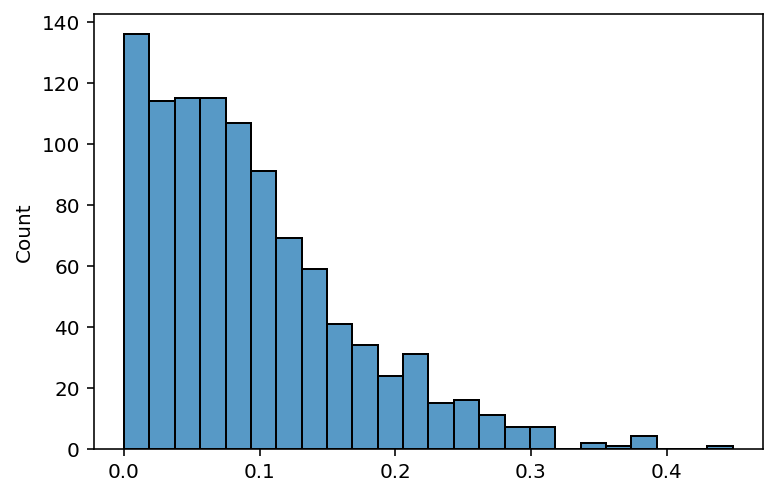

In [71]:
sns.histplot(test_stats, thresh=obs_stat)

In [72]:
p_val = (test_stats >= obs_stat).mean()
p_val

0.598

Pick a significance level 0.05, this is much higher than the threshold. Hence, we failed to reject our null hypothesis. This is saying that, according to our test, the urban population percentage has limited or no influence on the recall score. We failed to observe any parity between high urban population percentage areas and low urban population percentage areas when predicting the outage categories. 